In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## Fourier and Bspline basis

In [12]:
class fourier_basis():
    def __init__(self, interval = [0, 1], n = 5):
        """Fourier basis:
        Args:
            interval: range over which we define our basis
            n: numbers of functions in the Fourier basis
        """
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.functions = []
        for i in range(0, self.n+1):
            if i%2 == 1:
                self.functions.append(lambda x, i=i: np.sin(2 * np.pi * ((i//2) + 1) * x / (self.end - self.start)))
            else: 
                self.functions.append(lambda x, i=i: np.cos(2 * np.pi * (i//2) * x / (self.end - self.start)))

    def deriv(self, k):
        """Returns the n-th derivatives of the Fourier basis functions"""
        derivatives = []        
        for i in range (len(self.functions)):    
            freq = 2 * np.pi * ((i // 2) + (1 if i % 2 == 1 else 0)) / (self.end - self.start)            
            if i % 2 == 1:  # Sine function
                if k % 4 == 0:
                    derivatives.append(lambda x, freq=freq: freq ** k * np.sin(freq * x))
                elif k%4 == 1:
                    derivatives.append(lambda x, freq=freq: freq ** k * np.cos(freq * x))  
                elif k%4 == 2:
                    derivatives.append(lambda x, freq=freq: - freq ** k * np.sin(freq * x))  
                else:
                    derivatives.append(lambda x, freq=freq: - freq ** k * np.cos(freq * x))   
            else:  # Cosine function
                if k % 4 == 0:
                    derivatives.append(lambda x, freq=freq: freq ** k * np.cos(freq * x))
                elif k%4 == 1:
                    derivatives.append(lambda x, freq=freq: - freq ** k * np.sin(freq * x))  
                elif k%4 == 2:
                    derivatives.append(lambda x, freq=freq: - freq ** k * np.cos(freq * x))  
                else:
                    derivatives.append(lambda x, freq=freq: freq ** k * np.sin(freq * x))  

        new_basis = fourier_basis(interval=[self.start, self.end], n=self.n)
        new_basis.functions = derivatives
        return new_basis

    def integral(self, k):
        """Returns the n-th derivatives of the Fourier basis functions"""
        integrals = []        
        for i in range (len(self.functions)):    
            freq = 2 * np.pi * ((i // 2) + (1 if i % 2 == 1 else 0)) / (self.end - self.start)   
            if i == 0:
                integrals.append(lambda x, freq=freq: np.ones_like(x))         
            elif i % 2 == 1:  # Sine function
                if k % 4 == 0:
                    integrals.append(lambda x, freq=freq: 1/(freq ** k) * np.sin(freq * x))
                elif k%4 == 1:
                    integrals.append(lambda x, freq=freq: - 1/(freq ** k) * np.cos(freq * x))  
                elif k%4 == 2:
                    integrals.append(lambda x, freq=freq: - 1/(freq ** k) * np.sin(freq * x))  
                else:
                    integrals.append(lambda x, freq=freq: 1/(freq ** k) * np.cos(freq * x))   
            else:  # Cosine function
                if k % 4 == 0:
                    integrals.append(lambda x, freq=freq: 1/(freq ** k) * np.cos(freq * x))
                elif k%4 == 1:
                    integrals.append(lambda x, freq=freq: 1/(freq ** k) * np.sin(freq * x))  
                elif k%4 == 2:
                    integrals.append(lambda x, freq=freq: - 1/(freq ** k) * np.cos(freq * x))  
                else:
                    integrals.append(lambda x, freq=freq: - 1/(freq ** k) * np.sin(freq * x))  

        new_basis = fourier_basis(interval=[self.start, self.end], n=self.n)
        new_basis.functions = integrals
        return new_basis


    def roughness_penalty(self, values):
        second_derivative_basis = self.deriv(2)
        penalty_matrix = np.zeros((self.n+1, self.n+1))
        x_vals = values
        dx = (self.end - self.start) / (len(values) - 1)
        for i in range(self.n+1):
            for j in range(self.n+1):
                f_i = second_derivative_basis.functions[i](x_vals)
                f_j = second_derivative_basis.functions[j](x_vals)
                # Approximate integral as otherwise we need to define product between functions (ie symbolic programming)
                penalty_matrix[i, j] = np.trapz(y = f_i * f_j, x = x_vals, dx = dx)
        
        return penalty_matrix

    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        plt.xlim([self.start, self.end])
        plt.show()

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

In [9]:
class bspline_basis():
    def __init__(self, interval = [0, 1], n = 5, order = 4, breaks = None):
        """Bspline basis:
        Args:
            interval: range over which we define our basis
            n: numbers of functions in the bspline basis
            order: order of each bspline (4 is cubic)
            breaks: where to put the breaks (if given)
        """
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.order = order
        self.functions = []
        if breaks is None:
            n_breaks = max(2, self.n - self.order + 2)  # Ensure at least two breaks
            self.breaks = np.linspace(self.start, self.end, n_breaks)
        else:
            self.breaks = np.array(breaks)
        self.knots = self.compute_knots(self.order)
        self.functions = [self.basis_function(i, self.order) for i in range(len(self.knots) - self.order)]

    def compute_knots(self, order):
        """Create the sequence of knots needed for the bsplines of order order"""
        t_start = np.repeat(self.start, order)
        t_end = np.repeat(self.end, order)
        internal_knots = self.breaks[1:-1]
        return np.concatenate([t_start, internal_knots, t_end])

    def basis_function(self, i, k):
        """Cox-de Boor recursion implementation"""
        if k == 1:
            def b(x):
                # Handling the discontinuity for the last spline
                if i == len(self.knots) - self.order - 1:
                    return np.where((self.knots[i] <= x) & (x <= self.knots[i + 1]), 1.0, 0.0)
                else:
                    return np.where((self.knots[i] <= x) & (x < self.knots[i + 1]), 1.0, 0.0)
            return b
        else:
            def b(x):
                left = np.zeros_like(x, dtype=float)
                right = np.zeros_like(x, dtype=float)
                if self.knots[i + k - 1] != self.knots[i]:
                    left = ((x - self.knots[i]) / (self.knots[i + k - 1] - self.knots[i])) * self.basis_function(i, k - 1)(x)
                if self.knots[i + k] != self.knots[i + 1]:
                    right = ((self.knots[i + k] - x) / (self.knots[i + k] - self.knots[i + 1])) * self.basis_function(i + 1, k - 1)(x)
                return left + right
            return b

    def deriv(self, k=1):
        """Return a new bspline_basis object representing the nth derivative"""
        def derivative_basis_function(i, j, k):
            if k == 0:
                return self.basis_function(i, j)  # Base case: return the original basis function
            elif j == 1 or k >= j:
                return lambda x: np.zeros_like(x, dtype=float)  # Higher order derivatives of zero order are zero
            else:
                def b(x):
                    left = np.zeros_like(x, dtype=float)
                    right = np.zeros_like(x, dtype=float)
                    if self.knots[i + j] != self.knots[i]:
                        left = ((j) / (self.knots[i + j] - self.knots[i])) * derivative_basis_function(i, j - 1, k - 1)(x)
                    if i + j + 1 < len(self.knots) and self.knots[i + j + 1] != self.knots[i + 1]:
                        right = ((-j) / (self.knots[i + j + 1] - self.knots[i + 1])) * derivative_basis_function(i + 1, j - 1, k - 1)(x)
                    return left + right
                return b

        new_basis = bspline_basis(interval=[self.start, self.end], breaks=self.breaks, order=self.order - k)
        new_basis.functions = [derivative_basis_function(i, self.order, k) for i in range(len(self.knots) - self.order)]
        return new_basis

    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        for br in self.knots[self.order:-self.order]:
            plt.axvline(br, c='r', linestyle = 'dashed', alpha=0.5)
        plt.xlim([self.start, self.end])
        plt.show()

    def roughness_penalty(self, values):
        second_derivative_basis = self.deriv(2)
        penalty_matrix = np.zeros((self.n, self.n))
        x_vals = values
        dx = (self.end - self.start) / (len(values) - 1)
        for i in range(self.n):
            for j in range(self.n):
                f_i = second_derivative_basis.functions[i](x_vals)
                f_j = second_derivative_basis.functions[j](x_vals)
                # Approximate integral as otherwise we need to define product between functions (ie symbolic programming)
                penalty_matrix[i, j] = np.trapz(y = f_i * f_j, x = x_vals, dx = dx)
                        
        return penalty_matrix

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

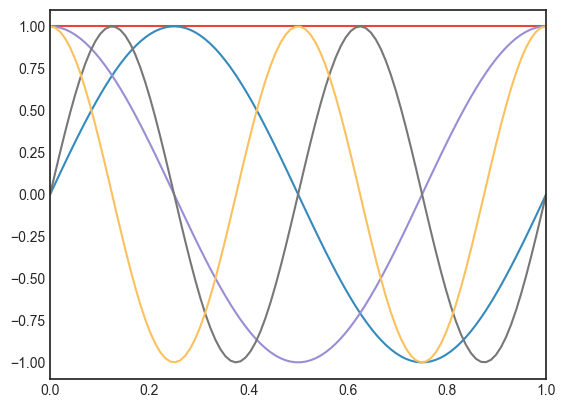

In [13]:
fourier_basis(n=4).plot()

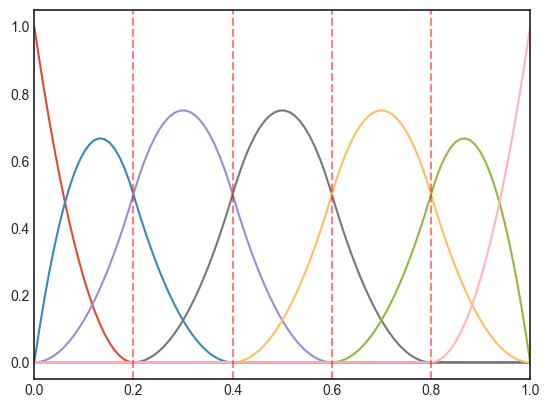

In [14]:
# Plotting 10 cubic splines
bspline_basis(n = 7, order = 3).plot()

## Smoothing functions on the Canadian weather data

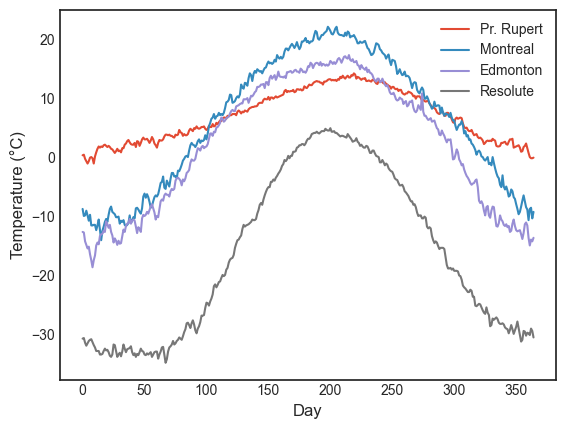

In [49]:
data = pd.read_table('canweather.tsv')
cities = ['Pr. Rupert.Temperature.C', 'Montreal.Temperature.C', 'Edmonton.Temperature.C', 'Resolute.Temperature.C']
data_cities = data[cities]
stations = data_cities.columns
temp = data_cities.values
plt.plot(np.arange(len(temp)),temp)
plt.legend(stations)
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.legend(['Pr. Rupert', 'Montreal', 'Edmonton', 'Resolute'])
plt.savefig('pictures/weather_plot.png')
plt.show()

In [75]:
def ols_fit(input, targets, base_type = 'fourier', n = 5, order_bspline = 4, lbd_l1 = 0, lbd_roughness = 0):
    roughness = 0
    if base_type == 'fourier':
        X = fourier_basis(n=n, interval=input).evaluate(input).T
        if lbd_roughness != 0:
            roughness = fourier_basis(n=n, interval=input).roughness_penalty(input)
    elif base_type == 'bspline':
        X = bspline_basis(n=n, order=order_bspline, interval=input).evaluate(input).T
        if lbd_roughness != 0:
            roughness = bspline_basis(n=n, order=order_bspline, interval=input).roughness_penalty(input)
    y = targets
    b = np.linalg.solve(X.T @ X + lbd_roughness * roughness + lbd_l1 * np.eye(X.shape[1]), X.T @ y)
    
    return X @ b


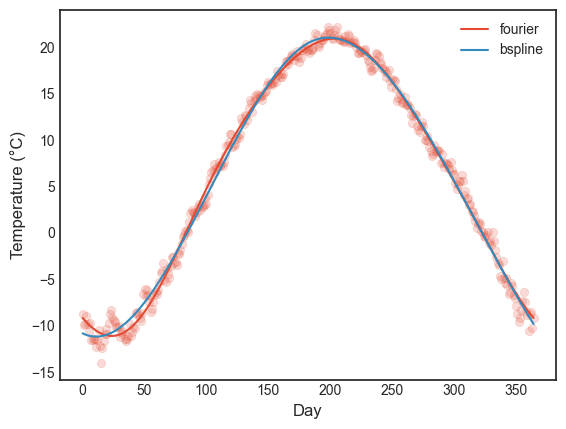

In [32]:
# Comparing bsplines and fourier basis smoothing
montreal = temp[:,1]
day = np.arange(len(montreal))
plt.scatter(day, montreal, alpha = 0.2)
for j in ['fourier', 'bspline']:
    plt.plot(day, ols_fit(day, montreal, base_type=j), label=j)
plt.legend()
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.savefig('pictures/weather_smooth.png')
plt.show()

## Speed (derivative)

In [74]:
def ols_fit_deriv(input, targets, base_type = 'fourier', n = 5, order_bspline = 4, order_d = 1, lbd_l1 = 0, lbd_roughness = 0):
    roughness = 0
    if base_type == 'fourier':
        X = fourier_basis(n=n, interval=input).evaluate(input).T
        derivatives = fourier_basis(n=n, interval=input).deriv(k=order_d).evaluate(input).T
        if lbd_roughness != 0:
            roughness = fourier_basis(n=n, interval=input).roughness_penalty(input)
    elif base_type == 'bspline':
        X = bspline_basis(n=n, order = order_bspline, interval=input).evaluate(input).T
        derivatives = bspline_basis(n=n, order = order_bspline, interval=input).deriv(k=order_d).evaluate(input).T
        if lbd_roughness != 0:
            roughness = bspline_basis(n=n, order = order_bspline, interval=input).roughness_penalty(input)
    y = targets
    b = np.linalg.solve(X.T @ X + lbd_roughness * roughness + lbd_l1 * np.eye(X.shape[1]), X.T @ y)

    return derivatives @ b

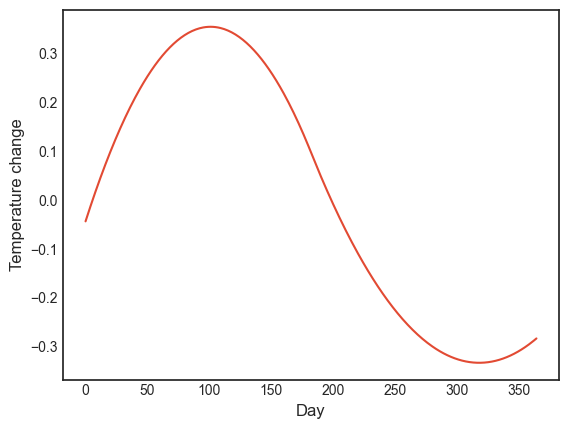

In [55]:
plt.plot(day, ols_fit_deriv(day, montreal, base_type='bspline', n=5))
plt.xlabel('Day')
plt.ylabel('Temperature change')
plt.savefig('pictures/weather_deriv.png')
plt.show()

## Confidence interval

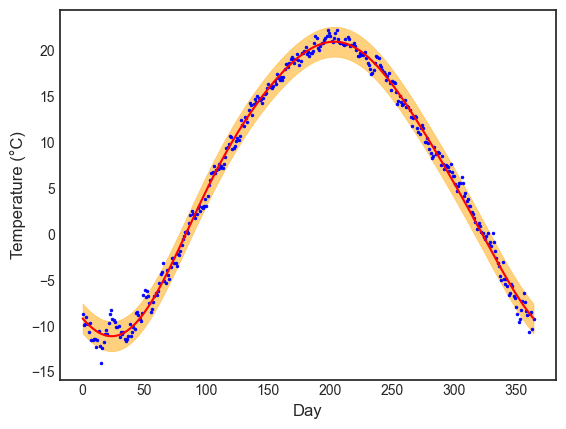

In [34]:
nbasis = 5
fourier_pred = ols_fit(day, montreal, base_type='fourier', n = nbasis)
# Estimating the 95% confidence interval
var = np.sum((fourier_pred - montreal) ** 2) / (365 - nbasis)
plt.fill_between(day, fourier_pred - 2 * np.sqrt(var), fourier_pred + 2 * np.sqrt(var), alpha = 0.5, color='orange')
plt.plot(day, fourier_pred, c='r')
plt.scatter(day, montreal, s=4, c='b')
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.savefig('pictures/weather_confidence.png')
plt.show()

## Number of components in the Fourier basis

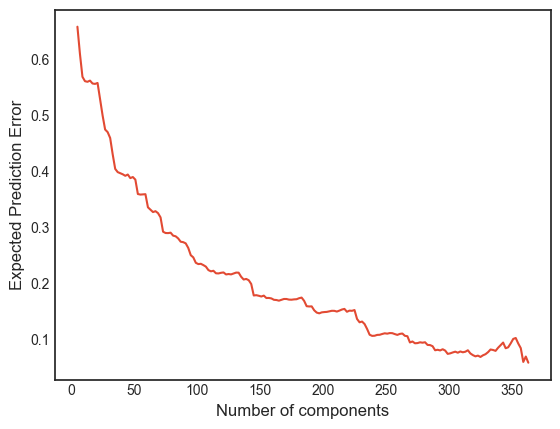

In [35]:
comp = np.arange(5, 364, 2).astype(int)
err = np.zeros(len(comp))
for i, k in enumerate(comp):
    pred = ols_fit(day, montreal, base_type='fourier', n = k)
    err[i] = np.sum((pred - montreal) ** 2) / (365 - k)
plt.plot(comp, err)
plt.xlabel('Number of components')
plt.ylabel('Expected Prediction Error')
plt.savefig('pictures/nb_components.png')
plt.show()

## Optimal lambda parameter 

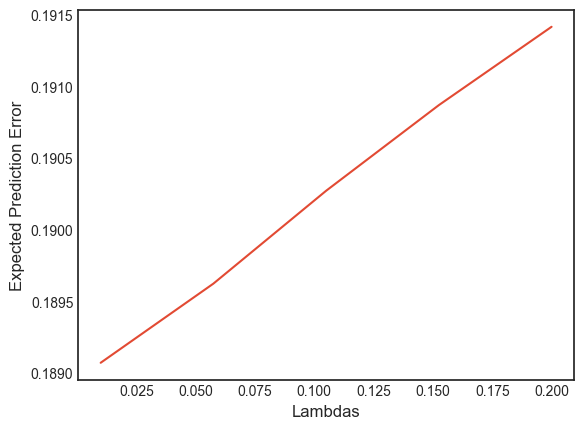

In [26]:
# Right now it's only ridge regression but we should evaluate the roughness too
lambdas = np.linspace(0.01, 0.20, 5)
err_lbd = np.zeros(len(lambdas))
for i, k in enumerate(lambdas):
    pred = ols_fit(day, montreal, base_type='bspline', lbd_roughness=k, n = 100)
    err_lbd[i] = np.sum((pred - montreal) ** 2) / (365 - k)
plt.plot(lambdas, err_lbd)
plt.xlabel('Lambdas')
plt.ylabel('Expected Prediction Error')
plt.show()

## Age data

In [27]:
age_data = pd.read_csv('age_data.tsv', delimiter ='\t')

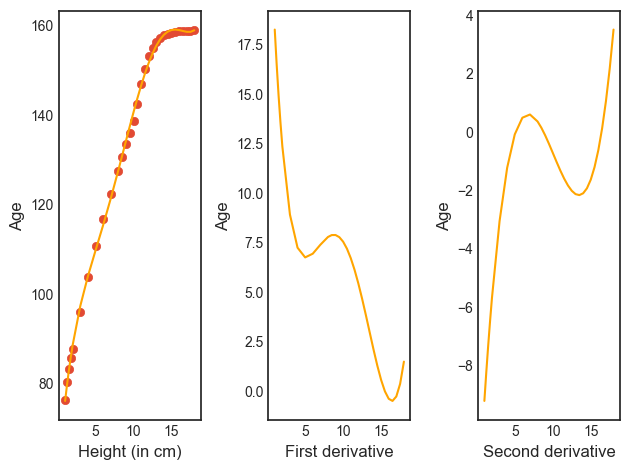

In [97]:
age = age_data['value'].values
first_girl = age_data['girl01'].values
fig, ax = plt.subplots(1,3)
order = 6
ax[0].scatter(age, first_girl)
ax[0].plot(age, ols_fit(age, first_girl, 'bspline', n = 5, order_bspline=order), c="orange")
ax[0].set_xlabel('Height (in cm)')
ax[0].set_ylabel('Age')
ax[1].plot(age, ols_fit_deriv(age, first_girl, 'bspline', n = 5, order_bspline=order, order_d=1), c="orange")
ax[1].set_xlabel('First derivative')
ax[1].set_ylabel('Age')
ax[2].plot(age, ols_fit_deriv(age, first_girl, 'bspline', n = 5, order_bspline=order, order_d=2), c="orange")
ax[2].set_xlabel('Second derivative')
ax[2].set_ylabel('Age')
plt.tight_layout()
plt.savefig('pictures/age_bspline.png')
plt.show()

## FPCA

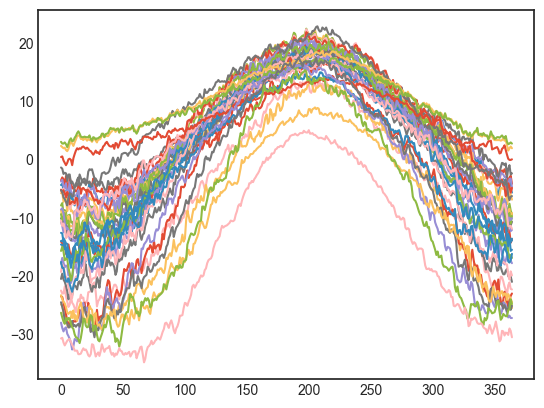

In [29]:
temp_all = data.loc[:,data.columns.str.endswith('C')].values
plt.plot(np.arange(len(temp_all)), temp_all)
plt.show()

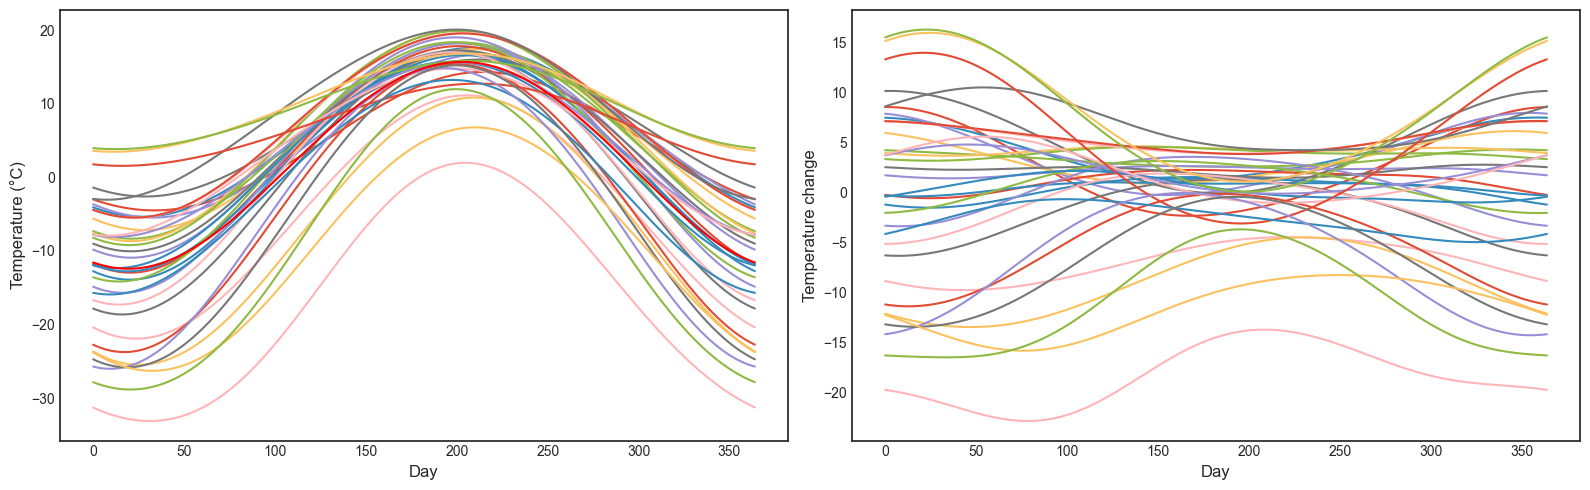

In [122]:
day = np.arange(len(temp_all))
pred = []
res = []
res_dev = []
fig, ax = plt.subplots(1,2, figsize=(16,5))
for i in range(temp_all.shape[1]):
    pred.append(ols_fit(day, temp_all[:,i], n = 8, lbd_roughness=1e6))
    ax[0].plot(day, pred[-1])
pred = np.array(pred)
mean_f = np.mean(pred,axis=0)
ax[0].plot(day, mean_f, c = 'r')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Temperature (°C)')
for i in range(temp_all.shape[1]):
    res.append(pred[i] - mean_f)
    ax[1].plot(day, res[-1])
res = np.array(res)
cov_res = np.cov(res.T)
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Temperature change')
plt.tight_layout()
plt.show()

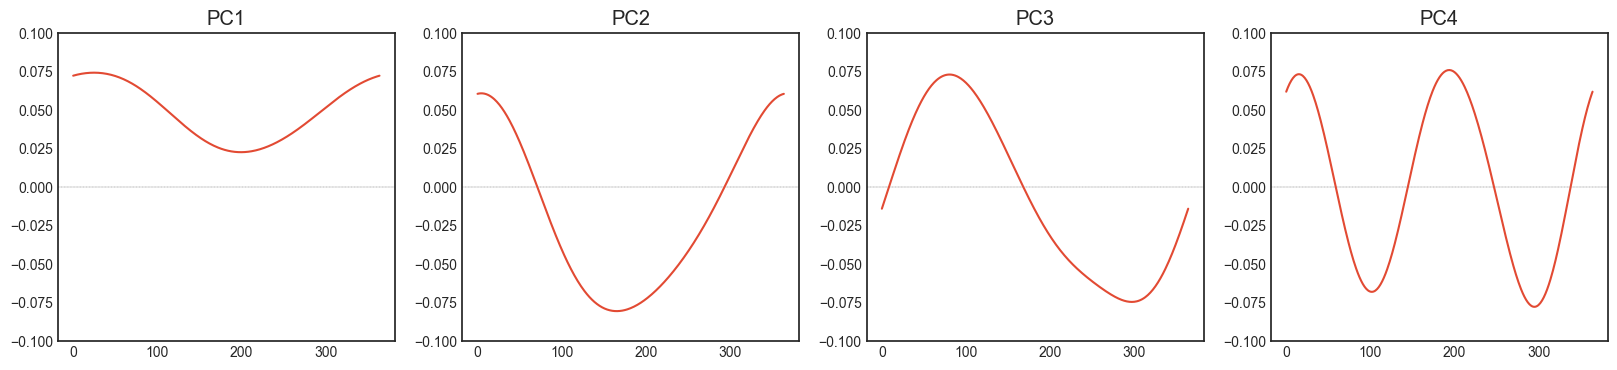

In [153]:
U,V,D = np.linalg.svd(cov_res)
fig, ax = plt.subplots(1, 4, figsize = (20,4))
sense = [-1, -1, 1, -1]
for i in range(4):
    ax[i].set_title(f'PC{i+1}')
    ax[i].axhline(0, c ='black', linestyle = 'dashed', linewidth = 0.2)
    ax[i].plot(day, sense[i] * D[i])
    ax[i].set_ylim(-0.10,0.10)
plt.show()